# Install Package

In [ ]:
!pip install spams
!pip install staintools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 34.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for spams: filename=spams-2.6.5.4-cp38-cp38-linux_x86_64.whl size=3241014 sha256=d61e612fb4c81dad9e9fd1a54b94ee11a98cf2c205814889066b9a495d1506a3
  Stored in directory: /root/.cache/pip/wheels/38/d6/cd/b79299cdb26aa57760dbbeb096bc8b71b10c69f4bb95dbd16c
Successfully built spams
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14072 sha256=f80210211c48cbcccfa746fc1789f89dfc09fb954706a7ca5030e8e020a83bb0
  Stored in directory: /root/.cache/pip/wheels/09/ed/d3/94d11aa73ab04cc3a727faa6ee8618ff540877cb98a7abb14e
Successfully built staintools


# Import Libraries

In [ ]:
import itertools
import os
import statistics
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import PIL
from google.colab import drive
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle 
import sklearn
import sklearn.model_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from keras import backend as K
from sklearn.utils import class_weight 
import pathlib
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc,  roc_curve, balanced_accuracy_score, cohen_kappa_score
from scipy import interp
import time
import sys
import staintools
import cv2 as cv

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.9.2
Hub version: 0.12.0
GPU is available


# Mount Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Initialise Functions

In [ ]:
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))



def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


def create_model(model, class_weights):

  model_handle_map = {
  "EB0V2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "EB0V2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "EB0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "RV1": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5",
  "RV2": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5",
  "MB1": "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5",
  "MB2": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5",
  }
  
  model_handle = model_handle_map.get(model)
  print(f"Selected model: {model} : {model_handle}")
  print("Building model with", model_handle)
  do_fine_tuning = False

  data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),                                       
  ])


  base_model = hub.KerasLayer(model_handle, trainable=do_fine_tuning)
  dense_layer = tf.keras.layers.Dense(256, activation='relu')
  prediction_layer = tf.keras.layers.Dense(4, activation='softmax')

  inputs = tf.keras.Input(shape=IMAGE_SIZE+(3,))
  x = data_augmentation(inputs)
  x = base_model(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = dense_layer(x)
  x = tf.keras.layers.Dropout(0.4)(x) 
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs, name = model)

  weights = np.fromiter(class_weights.values(), dtype=float)
  print('Class weights:',weights)
  loss = weighted_categorical_crossentropy(weights)

  model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
  loss=loss,
  metrics=['accuracy'])

  model.summary()
  
  return model




def plot_confusion_matrix(cm, classes, dir,
                          normalize=False,
                          title='Confusion matrix',
                          
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(dir)
    plt.close()



# Temp 1

# Setup SN Dataset

In [ ]:
# Reinhard
sn_label = 'V'
temp_img = 'Temp1'

# original dataset
base_path = "/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset"

# temp image path
temp_img_path = f"/content/drive/Shareddrives/Unlimited Drive/SN/Template/{temp_img}.png"

#  make a temp directory to save SN dataset
save_path = f'/content/{sn_label}_{temp_img}'
if not os.path.exists(save_path):
  os.mkdir(save_path)

# Setup Hyperparameters and directories

In [ ]:
# Set hyperparameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 100
print('Batch size:', BATCH_SIZE, 'Epoch: ', EPOCHS)

best_weight_dir = f'/content/drive/Shareddrives/Unlimited Drive/SN/Weight/{sn_label}_{temp_img}'
if not os.path.exists(best_weight_dir):
   os.mkdir(best_weight_dir)

   
figure_dir = '/content/drive/Shareddrives/Unlimited Drive/SN/Result/Figures'




metrics = {'Model Name': [], 'Balanced Accuracy': [], 'Macro Precision': [], 'Macro Recall': [], 'Macro F1score': [], 'Kappa Score': []}
result_dir = f'/content/drive/Shareddrives/Unlimited Drive/SN/Result/{sn_label}_{temp_img}_result.csv'
if not os.path.exists(result_dir):
  df = pd.DataFrame(metrics) 
  df.to_csv(result_dir, index=False) 

Batch size: 16 Epoch:  100


# Form SPCN-normalised datasets

In [ ]:
# Define normalizer
normalizer = staintools.StainNormalizer(method="vahadane")

# Read template image
print(temp_img_path)
normalizer.fit(staintools.read_image(temp_img_path))

print(f'Folder contains {len(os.listdir(base_path))} folders')
print(os.listdir(base_path))

print('')

for type_folder in os.listdir(base_path):
  type_path = os.path.join(base_path, type_folder)
  print(f'In Folder :{type_path}')
  print('')

  for grade_folder in os.listdir(type_path):
    grade_path = os.path.join(type_path, grade_folder)
    print(f'In Folder :{grade_path}')
    print('')

    for files in os.listdir(grade_path):
      
      image_path = os.path.join(grade_path, files)
      im = normalizer.transform(staintools.read_image(image_path))


      saveim_path = os.path.join(save_path, type_folder, grade_folder)
      if not os.path.exists(saveim_path):
        os.makedirs(saveim_path)

        
      os.chdir(saveim_path) 
      file_name = str(files)
      cv.imwrite(file_name,im)

 

/content/drive/Shareddrives/Unlimited Drive/SN/Template/Temp1.png
Folder contains 2 folders
['Training Set', 'Test Set']

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_1

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_3

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_0 

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_2

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_2

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_1

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_0

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/T

# Train and Test Models

Found 711 files belonging to 4 classes.
Found 177 files belonging to 4 classes.
['Grade_0 ', 'Grade_1', 'Grade_2', 'Grade_3']
Selected model: EB0 : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Building model with https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                        

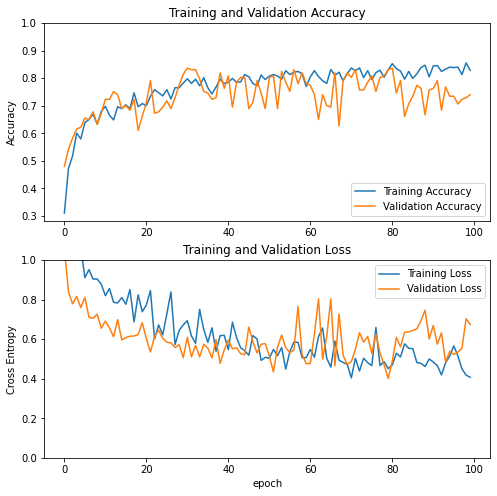

12/12 [==============================] - 0s 35ms/step - loss: 0.6096 - accuracy: 0.8362
Test accuracy : 0.8361582159996033
12/12 [==============================] - 1s 29ms/step
Confusion matrix, without normalization
[[102  13   3   0]
 [  1  20   0   0]
 [  1   4  15   0]
 [  0   3   4  11]]
Normalized confusion matrix
[[0.86440678 0.11016949 0.02542373 0.        ]
 [0.04761905 0.95238095 0.         0.        ]
 [0.05       0.2        0.75       0.        ]
 [0.         0.16666667 0.22222222 0.61111111]]

Accuracy: 0.8362


Balanced Accuracy: 0.7945

Macro Precision: 0.7906
Macro Recall: 0.7945
Macro F1-score: 0.7619

Kappa score: 0.7080

Classification Report

              precision    recall  f1-score   support

    Grade_0        0.98      0.86      0.92       118
     Grade_1       0.50      0.95      0.66        21
     Grade_2       0.68      0.75      0.71        20
     Grade_3       1.00      0.61      0.76        18

    accuracy                           0.84       177
   

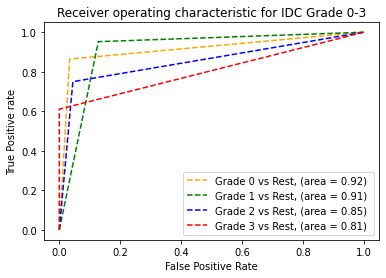

Selected model: EB0V2 : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1280)              5919312   
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               327

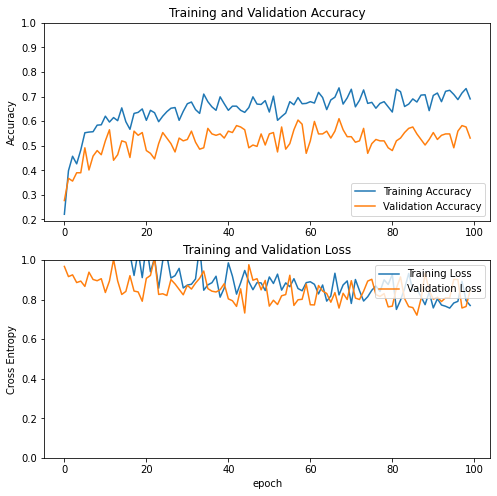

12/12 [==============================] - 0s 33ms/step - loss: 0.7575 - accuracy: 0.6102
Test accuracy : 0.6101694703102112
12/12 [==============================] - 1s 24ms/step
Confusion matrix, without normalization
[[64 47  5  2]
 [ 1 15  2  3]
 [ 1  7 11  1]
 [ 0  0  0 18]]
Normalized confusion matrix
[[0.54237288 0.39830508 0.04237288 0.01694915]
 [0.04761905 0.71428571 0.0952381  0.14285714]
 [0.05       0.35       0.55       0.05      ]
 [0.         0.         0.         1.        ]]

Accuracy: 0.6102


Balanced Accuracy: 0.7017

Macro Precision: 0.6370
Macro Recall: 0.7017
Macro F1-score: 0.6163

Kappa score: 0.4266

Classification Report

              precision    recall  f1-score   support

    Grade_0        0.97      0.54      0.70       118
     Grade_1       0.22      0.71      0.33        21
     Grade_2       0.61      0.55      0.58        20
     Grade_3       0.75      1.00      0.86        18

    accuracy                           0.61       177
   macro avg       

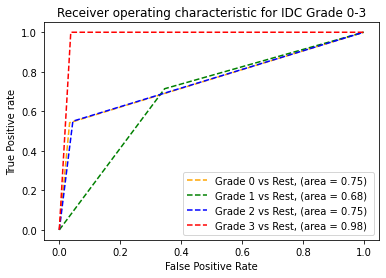

Selected model: EB0V2-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2
Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0V2-21k"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_2 (KerasLayer)  (None, 1280)              5919312   
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 256)        

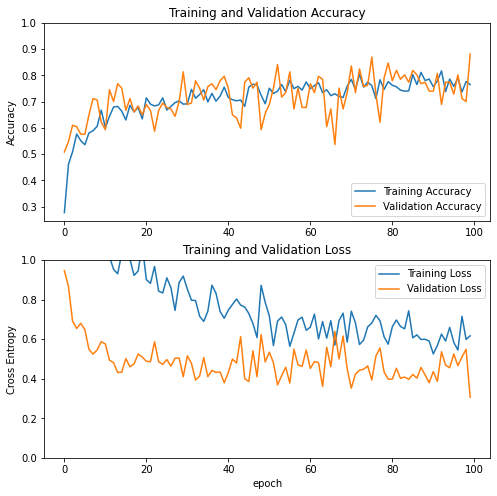

12/12 [==============================] - 0s 35ms/step - loss: 0.3062 - accuracy: 0.8814
Test accuracy : 0.8813559412956238
12/12 [==============================] - 1s 24ms/step
Confusion matrix, without normalization
[[105   3   5   5]
 [  0  16   2   3]
 [  0   2  18   0]
 [  0   0   1  17]]
Normalized confusion matrix
[[0.88983051 0.02542373 0.04237288 0.04237288]
 [0.         0.76190476 0.0952381  0.14285714]
 [0.         0.1        0.9        0.        ]
 [0.         0.         0.05555556 0.94444444]]

Accuracy: 0.8814


Balanced Accuracy: 0.8740

Macro Precision: 0.7836
Macro Recall: 0.8740
Macro F1-score: 0.8192

Kappa score: 0.7879

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.89      0.94       118
     Grade_1       0.76      0.76      0.76        21
     Grade_2       0.69      0.90      0.78        20
     Grade_3       0.68      0.94      0.79        18

    accuracy                           0.88       177
   

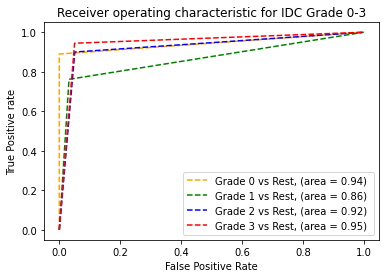

Selected model: RV1 : https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "RV1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_3 (KerasLayer)  (None, 2048)              23561152  
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                              

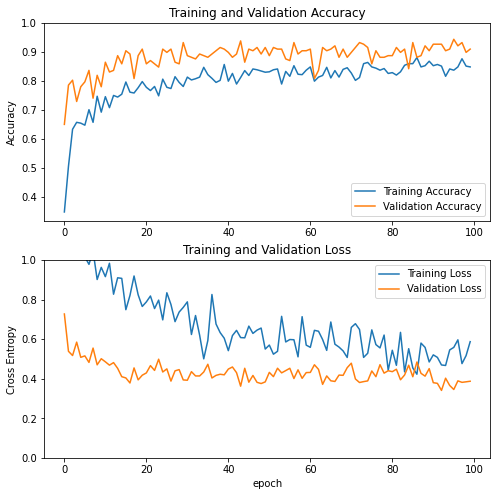

12/12 [==============================] - 1s 46ms/step - loss: 0.3456 - accuracy: 0.9435
Test accuracy : 0.9435028433799744
12/12 [==============================] - 1s 39ms/step
Confusion matrix, without normalization
[[116   2   0   0]
 [  0  17   0   4]
 [  0   1  18   1]
 [  0   1   1  16]]
Normalized confusion matrix
[[0.98305085 0.01694915 0.         0.        ]
 [0.         0.80952381 0.         0.19047619]
 [0.         0.05       0.9        0.05      ]
 [0.         0.05555556 0.05555556 0.88888889]]

Accuracy: 0.9435


Balanced Accuracy: 0.8954

Macro Precision: 0.8797
Macro Recall: 0.8954
Macro F1-score: 0.8861

Kappa score: 0.8923

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.98      0.99       118
     Grade_1       0.81      0.81      0.81        21
     Grade_2       0.95      0.90      0.92        20
     Grade_3       0.76      0.89      0.82        18

    accuracy                           0.94       177
   

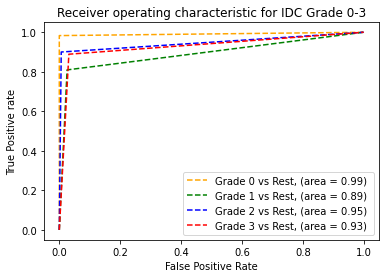

Selected model: RV2 : https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "RV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_4 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                              

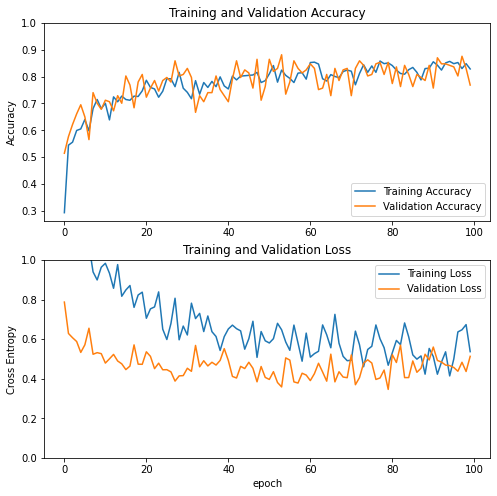

12/12 [==============================] - 1s 50ms/step - loss: 0.3587 - accuracy: 0.8814
Test accuracy : 0.8813559412956238
12/12 [==============================] - 1s 44ms/step
Confusion matrix, without normalization
[[107   6   2   3]
 [  0  17   1   3]
 [  0   3  17   0]
 [  0   1   2  15]]
Normalized confusion matrix
[[0.90677966 0.05084746 0.01694915 0.02542373]
 [0.         0.80952381 0.04761905 0.14285714]
 [0.         0.15       0.85       0.        ]
 [0.         0.05555556 0.11111111 0.83333333]]

Accuracy: 0.8814


Balanced Accuracy: 0.8499

Macro Precision: 0.7792
Macro Recall: 0.8499
Macro F1-score: 0.8095

Kappa score: 0.7854

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.91      0.95       118
     Grade_1       0.63      0.81      0.71        21
     Grade_2       0.77      0.85      0.81        20
     Grade_3       0.71      0.83      0.77        18

    accuracy                           0.88       177
   

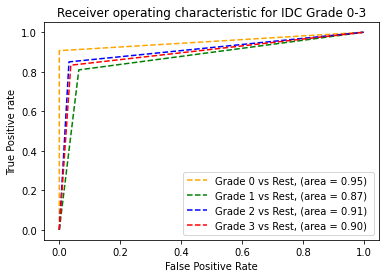

Selected model: MB1 : https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "MB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_5 (KerasLayer)  (None, 1024)              3228864   
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               262400    
              

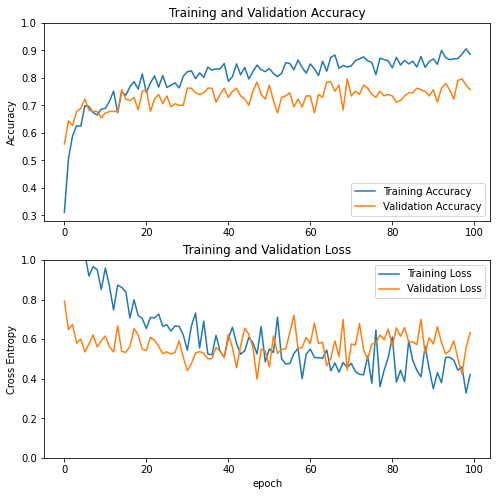

12/12 [==============================] - 0s 22ms/step - loss: 0.4436 - accuracy: 0.7966
Test accuracy : 0.7966101765632629
12/12 [==============================] - 0s 18ms/step
Confusion matrix, without normalization
[[92 11 10  5]
 [ 0 17  1  3]
 [ 0  3 17  0]
 [ 0  2  1 15]]
Normalized confusion matrix
[[0.77966102 0.09322034 0.08474576 0.04237288]
 [0.         0.80952381 0.04761905 0.14285714]
 [0.         0.15       0.85       0.        ]
 [0.         0.11111111 0.05555556 0.83333333]]

Accuracy: 0.7966


Balanced Accuracy: 0.8181

Macro Precision: 0.6884
Macro Recall: 0.8181
Macro F1-score: 0.7329

Kappa score: 0.6608

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.78      0.88       118
     Grade_1       0.52      0.81      0.63        21
     Grade_2       0.59      0.85      0.69        20
     Grade_3       0.65      0.83      0.73        18

    accuracy                           0.80       177
   macro avg       

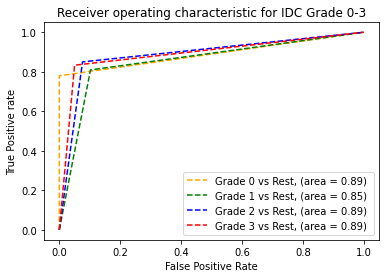

Selected model: MB2 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "MB2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_6 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_12 (Dropout)        (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
              

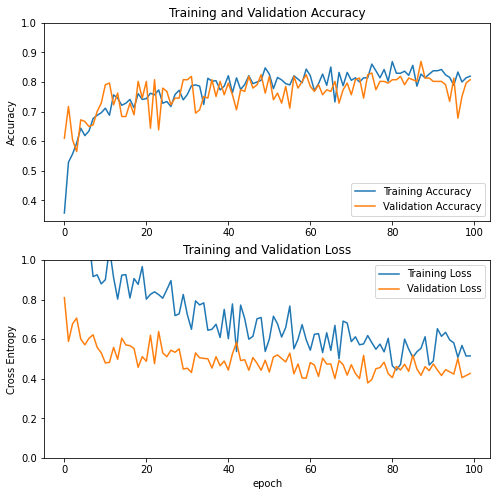

12/12 [==============================] - 0s 26ms/step - loss: 0.4172 - accuracy: 0.8701
Test accuracy : 0.8700565099716187
12/12 [==============================] - 1s 20ms/step
Confusion matrix, without normalization
[[105   9   0   4]
 [  0  15   3   3]
 [  0   3  17   0]
 [  0   0   1  17]]
Normalized confusion matrix
[[0.88983051 0.07627119 0.         0.03389831]
 [0.         0.71428571 0.14285714 0.14285714]
 [0.         0.15       0.85       0.        ]
 [0.         0.         0.05555556 0.94444444]]

Accuracy: 0.8701


Balanced Accuracy: 0.8496

Macro Precision: 0.7684
Macro Recall: 0.8496
Macro F1-score: 0.8014

Kappa score: 0.7676

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.89      0.94       118
     Grade_1       0.56      0.71      0.63        21
     Grade_2       0.81      0.85      0.83        20
     Grade_3       0.71      0.94      0.81        18

    accuracy                           0.87       177
   

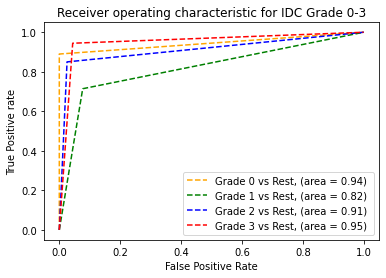

In [ ]:
model_list = ['EB0', 'EB0V2', 'EB0V2-21k', 'RV1', 'RV2', 'MB1', 'MB2']
train_dir =f'/content/{sn_label}_{temp_img}/Training Set'
test_dir =f'/content/{sn_label}_{temp_img}/Test Set'


train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size= IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  label_mode='categorical')

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  label_mode = 'categorical')

class_names = train_ds.class_names
print(class_names)

normalization_layer = tf.keras.layers.Rescaling(1. / 255)

train_ds = train_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))
test_ds = test_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

y = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = generate_class_weights(y, multi_class=True, one_hot_encoded=True)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


for model_name in model_list:
  model = create_model(model_name, class_weights)


  best_weight_path = f'{best_weight_dir}/{model_name}_best.h5'
  cp_callback = tf.keras.callbacks.ModelCheckpoint(best_weight_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 


  history=model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=EPOCHS,
  callbacks = [cp_callback], 
  class_weight = class_weights
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.savefig(f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_Train_Val_Curve.png')
  plt.show()
  plt.close()

  model.load_weights(best_weight_path)

  loss, accuracy = model.evaluate(test_ds)
  print('Test accuracy :', accuracy)

  test_labels = np.concatenate([y for x, y in test_ds], axis=0)
  predictions = model.predict(test_ds)
  y_pred = np.argmax(predictions, axis=1)
  y_label = np.argmax(test_labels, axis=1)

  cm = confusion_matrix(y_label, y_pred)
  plot_confusion_matrix(cm, classes= class_names, dir = f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_CM.png' )
  plot_confusion_matrix(cm, normalize = True, classes = class_names, dir = f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_CM_Norm.png')


  print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_label, y_pred)))
  print('\nBalanced Accuracy: {:.4f}\n'.format(balanced_accuracy_score(y_label, y_pred)))

  print('Macro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='macro')))
  print('Macro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='macro')))
  print('Macro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='macro')))
  print('Kappa score: {:.4f}'.format(cohen_kappa_score(y_label, y_pred)))

  print('\nClassification Report\n')
  print(classification_report(y_label, y_pred, target_names=class_names))

  baccuracy = round(balanced_accuracy_score(y_label, y_pred), 4)
  macro_precision = round(precision_score(y_label, y_pred, average='macro'), 4)
  macro_recall = round(recall_score(y_label, y_pred, average='macro'), 4)
  macro_f1score = round(f1_score(y_label, y_pred, average='macro'), 4)
  kappa_score = round(cohen_kappa_score(y_label, y_pred), 4)

  y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=4)
  y_label = tf.keras.utils.to_categorical(y_label, num_classes=4)

  # Plot ROC Curve
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_classes = 4
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_label[:,i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])


  plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Grade 0 vs Rest, (area = %0.2f) ' % roc_auc[0])
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Grade 1 vs Rest, (area = %0.2f) ' % roc_auc[1])
  plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Grade 2 vs Rest, (area = %0.2f) ' % roc_auc[2])
  plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Grade 3 vs Rest, (area = %0.2f) ' % roc_auc[3])
  plt.title('Receiver operating characteristic for IDC Grade 0-3')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.savefig(f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_ROC.png')
  plt.show()
  plt.close()



  df = pd.DataFrame({'Model Name': model_name, 'Balanced Accuracy': baccuracy, 'Macro Precision': macro_precision, 'Macro Recall': macro_recall, 'Macro F1score': macro_f1score, 'Kappa Score': kappa_score}, index=[0])  

  df.to_csv(result_dir,  mode='a', index=False, header=False) 


# This process is repeated with Temp2, Temp3, Temp4 and Temp5